# Test Evaluation with 150 Synthetic Graphs

In [10]:
#!/usr/bin/env python3
"""DQN agents trained on Breakthrough by independent Q-learning."""
import matplotlib.pyplot as plt
import sys
sys.path.append("../")

from utils.environment.game import GraphGame
from utils.environment.nodeCentrality import Node_Centrality
from utils.environment.globalFeature import Global_Feature
from utils.reinforcement_learning.rl_environment import Environment
from utils.validation import *
from utils.evaluation import jsonEncoder
from utils.evaluation.evaluationhelper import *
from utils.environment.envhelper import gen_new_graphs
from utils.reinforcement_learning.dqn_TS import DQN
from utils.hyperparameters.params import Params
from utils.getClass import objective_function,get_class_from_file
from tqdm import tqdm
import torch
import numpy as np
import wandb
import os, sys, getopt
def lowest_AUC(x,value):
    lowest_auc_index = np.argmin(value)
    return x[lowest_auc_index], value[lowest_auc_index]
def input_graph(graph_path,file):
    GRAPH = Graph.Read_Ncol(graph_path+str(file)+".txt", directed=False)
    nodes = [v.index for v in GRAPH.vs]
    map = {n:int(i) for i, n in enumerate(nodes)}
    GRAPH = reset(GRAPH)  
    Graph.simplify(GRAPH)
    return GRAPH, map
def get_graph(graphList): 
    graph_path =  "../Dataset/Real/"
    evaluation = []
    eval_x = []
    for x in graphList:
        G, _ = input_graph(graph_path,graph)
        NUM = G.vcount()
        x_value  =  np.flip(np.arange(NUM)[NUM:0:-1]/NUM)
        evaluation.append(G)
        eval_x.append(x_value)
    return evaluation, eval_x
#evaluation, eval_x = get_Validation(50)
def CV_evaluation(parameter_loc, evaluation, eval_x):  
    params = Params(parameter_loc)
    nodeCentrality = Node_Centrality(params.centrality_feature_name)
    globalFeature = Global_Feature(params.global_feature_name)
    objectiveFunction = objective_function("utils/environment/objectiveFunction.py",params.objective_function)
    GNN = get_class_from_file(params.GNN[0], params.GNN[1])
    file_list = []
    AUC = []
    x_label = []
    start = int(params.save_every)
    end = int(params.num_train_episodes)+start
    interval = int(params.save_every)
    model_path = params.checkpoint_dir+"_"
    for iteration in np.arange(start,end,interval):
        name = model_path+str(iteration)
        model = torch.load("../"+name)
        auc_individual = []
        for i in range(len(evaluation)):
            if objectiveFunction.__name__ == "numberConnectedComponent":
                condMaxNum = True
            else:
                condMaxNum = False
            G = evaluation[i].copy()
            N = G.vcount()
            game = GraphGame
            env = Environment(game)
            attacker = DQN(state_representation_size=params.centrality_features,
                                hidden_layers_sizes= params.hidden_layers,
                               global_feature_size = params.global_features)
            attacker._q_network.load_state_dict(model["_q_network"])
            attacker._optimizer.load_state_dict(model["_optimizer"])
            rewards, value, actions = EvaluateModel(env, objectiveFunction, nodeCentrality, globalFeature, attacker, G)
            x =  np.flip(np.arange(N)[N:0:-1]/N)
            auc = area_under_curve(condMaxNum,N,x[:len(value)],value)
            fraction = len(actions)/N
            auc_individual.append(auc)
        AUC.append(np.mean(auc_individual))
        x_label.append(iteration)
    AUC = np.array(AUC)
    x_label = np.array(x_label)
    return x_label, AUC

100%|█████████████████████████████████████████| 2/2 [1:31:19<00:00, 2739.88s/it]

(2, 2, 1000)
BA Graph
(298500.0, 0.381988525390625)
Different Graph
(87500.0, 0.3857421875)


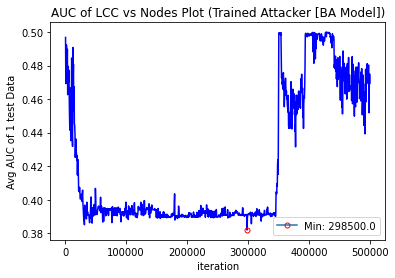

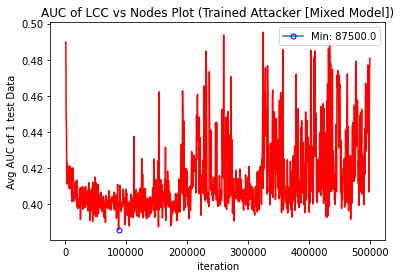

100%|█████████████████████████████████████████| 2/2 [5:03:58<00:00, 9119.13s/it]

(2, 2, 1000)
BA Graph
(66500.0, 0.10657388590506604)
Different Graph
(89500.0, 0.11560095804906373)


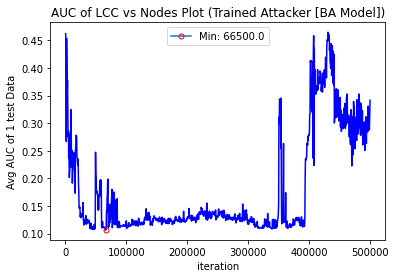

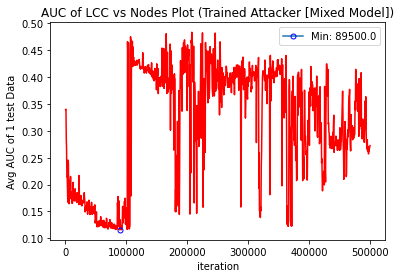

100%|████████████████████████████████████████| 2/2 [6:17:36<00:00, 11328.15s/it]

(2, 2, 1000)
BA Graph
(120000.0, 0.15385783559032687)
Different Graph
(177500.0, 0.09114378776929441)


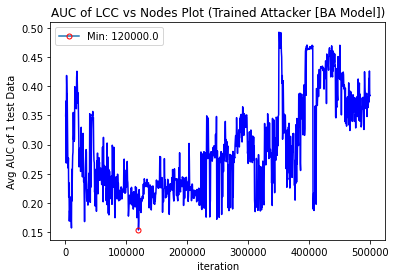

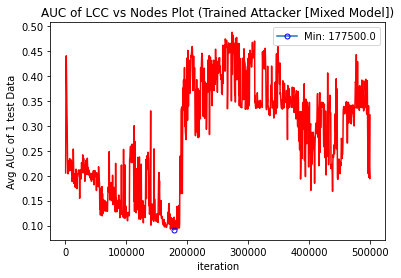

  0%|                                                     | 0/2 [03:03<?, ?it/s]


KeyboardInterrupt: 

In [5]:
from tqdm import tqdm
#path = "./model/DiffSize_Different_Graph/model_differentGraph_"
parameters = ["../utils/hyperparameters/BA/ba_params_MaxNum.json","../utils/hyperparameters/Mix/mixed_params_MaxNum.json"]
parameters = ["../utils/hyperparameters/BA/ba_params_Best_New.json","../utils/hyperparameters/Mix/mixed_params_Best_New.json"]

def getValue(graphList):
    evaluation, eval_x = get_graph(graphList)
    results = []
    for path in tqdm(range(2)):
        x, value = CV_evaluation(parameters[path],evaluation, eval_x)
        results.append([x,value])
        results_ts = np.array(results)
    print(results_ts.shape)     
    print("BA Graph")
    print(lowest_AUC(results_ts[0,0,:],results_ts[0,1,:]))
    print("Different Graph")
    print(lowest_AUC(results_ts[1,0,:],results_ts[1,1,:]))
    for j in range(2):
        if j == 0:
            color = 'blue'
            inv = 'red'
        else:
            color = 'red'
            inv = 'blue'
        if j == 0:
            name = "(Trained Attacker [BA Model])"
            save = "BA"

        else:
            name = "(Trained Attacker [Mixed Model])"
            save = "Diff"                    
        min_vc, min_value = lowest_AUC(results_ts[j,0,:],results_ts[j,1,:])
        plt.plot(results_ts[j,0,:],results_ts[j,1,:], color)
        plt.plot(min_vc, min_value, marker="o", markersize=5, markeredgecolor=inv, markerfacecolor="None",label="Min: "+str(min_vc))
        plt.title("AUC of LCC vs Nodes Plot "+""+str(name)) 
        plt.xlabel("iteration")
        plt.ylabel("Avg AUC of "+str(len(evaluation)) +" test Data")
        plt.legend()
        #plt.savefig("./Figure/Validation/Test_TS_100_"+save)
        plt.show()
for graph in ["foodweb-baywet","inf-USAir97","corruption",'household']:
    getValue([graph])

100%|█████████████████████████████████████████| 2/2 [1:49:05<00:00, 3272.69s/it]

(2, 2, 1000)
BA Graph
(54500.0, 0.07009899971889157)
Different Graph
(90500.0, 0.06984154541216588)


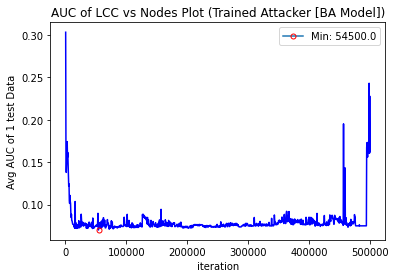

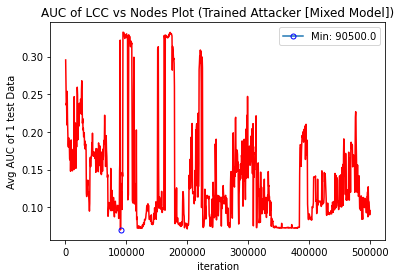

100%|███████████████████████████████████████████| 2/2 [57:42<00:00, 1731.07s/it]

(2, 2, 1000)
BA Graph
(294500.0, 0.2839730330339567)
Different Graph
(425500.0, 0.28457185039370075)


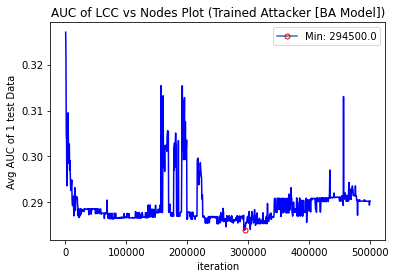

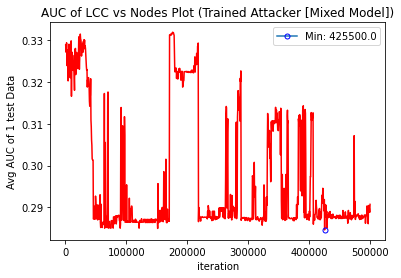

100%|█████████████████████████████████████████| 2/2 [2:15:37<00:00, 4068.67s/it]

(2, 2, 1000)
BA Graph
(192000.0, 0.06460223200726548)
Different Graph
(341000.0, 0.04916633988648317)


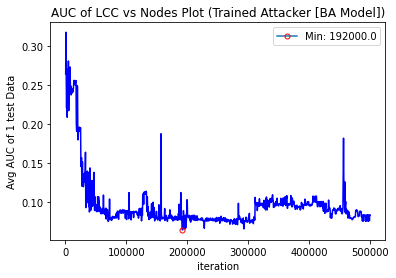

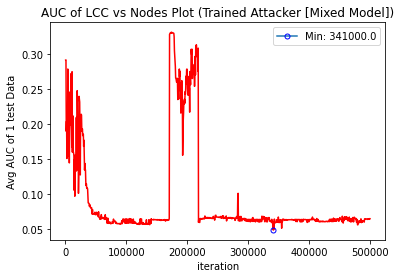

In [11]:
from tqdm import tqdm
#path = "./model/DiffSize_Different_Graph/model_differentGraph_"
parameters = ["../utils/hyperparameters/BA/ba_params_MaxNum.json","../utils/hyperparameters/Mix/mixed_params_MaxNum.json"]
parameters = ["../utils/hyperparameters/BA/ba_params_CN_New.json","../utils/hyperparameters/Mix/mixed_params_CN_New.json"]

def getValue(graphList):
    evaluation, eval_x = get_graph(graphList)
    results = []
    for path in tqdm(range(2)):
        x, value = CV_evaluation(parameters[path],evaluation, eval_x)
        results.append([x,value])
        results_ts = np.array(results)
    print(results_ts.shape)     
    print("BA Graph")
    print(lowest_AUC(results_ts[0,0,:],results_ts[0,1,:]))
    print("Different Graph")
    print(lowest_AUC(results_ts[1,0,:],results_ts[1,1,:]))
    for j in range(2):
        if j == 0:
            color = 'blue'
            inv = 'red'
        else:
            color = 'red'
            inv = 'blue'
        if j == 0:
            name = "(Trained Attacker [BA Model])"
            save = "BA"

        else:
            name = "(Trained Attacker [Mixed Model])"
            save = "Diff"                    
        min_vc, min_value = lowest_AUC(results_ts[j,0,:],results_ts[j,1,:])
        plt.plot(results_ts[j,0,:],results_ts[j,1,:], color)
        plt.plot(min_vc, min_value, marker="o", markersize=5, markeredgecolor=inv, markerfacecolor="None",label="Min: "+str(min_vc))
        plt.title("AUC of LCC vs Nodes Plot "+""+str(name)) 
        plt.xlabel("iteration")
        plt.ylabel("Avg AUC of "+str(len(evaluation)) +" test Data")
        plt.legend()
        #plt.savefig("./Figure/Validation/Test_TS_100_"+save)
        plt.show()
for graph in ["inf-USAir97","foodweb-baywet","corruption"]:
    getValue([graph])

100%|█████████████████████████████████████████| 2/2 [2:40:40<00:00, 4820.09s/it]

(2, 2, 1000)
BA Graph
(371500.0, 0.21600492880613364)
Different Graph
(237000.0, 0.18036235852500912)


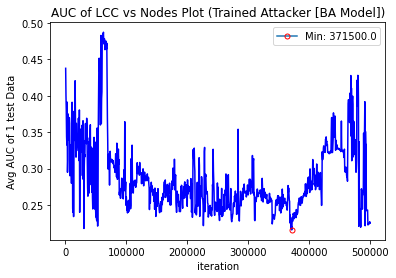

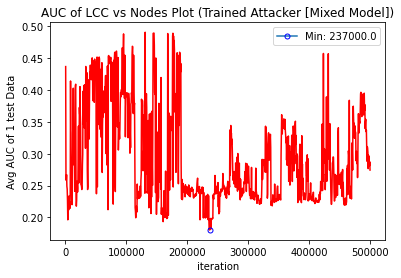

100%|█████████████████████████████████████████| 2/2 [1:03:27<00:00, 1903.70s/it]

(2, 2, 1000)
BA Graph
(32000.0, 0.4028087797619047)
Different Graph
(481000.0, 0.39586433531746035)


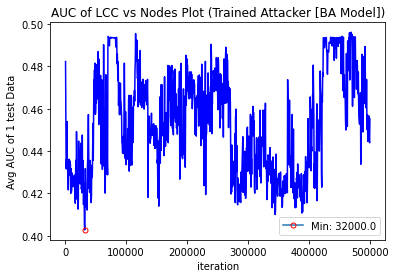

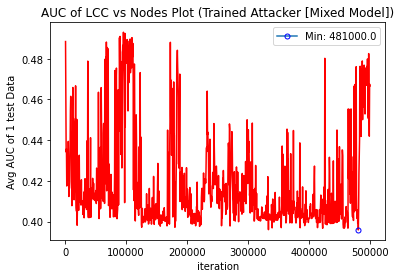

100%|█████████████████████████████████████████| 2/2 [4:06:20<00:00, 7390.04s/it]

(2, 2, 1000)
BA Graph
(68000.0, 0.41940482590683403)
Different Graph
(96500.0, 0.42879731823787987)


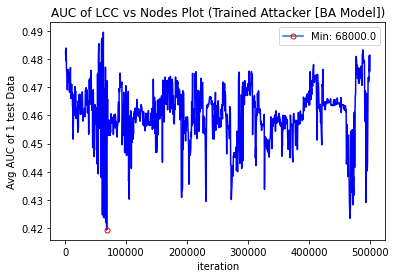

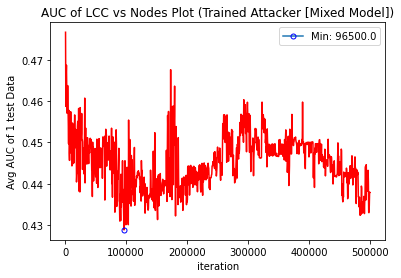

In [12]:
from tqdm import tqdm
#path = "./model/DiffSize_Different_Graph/model_differentGraph_"
parameters = ["../utils/hyperparameters/BA/ba_params_MaxNum.json","../utils/hyperparameters/Mix/mixed_params_MaxNum.json"]
parameters = ["../utils/hyperparameters/BA/ba_params_MaxNum_New.json","../utils/hyperparameters/Mix/mixed_params_MaxNum_New.json"]

def getValue(graphList):
    evaluation, eval_x = get_graph(graphList)
    results = []
    for path in tqdm(range(2)):
        x, value = CV_evaluation(parameters[path],evaluation, eval_x)
        results.append([x,value])
        results_ts = np.array(results)
    print(results_ts.shape)     
    print("BA Graph")
    print(lowest_AUC(results_ts[0,0,:],results_ts[0,1,:]))
    print("Different Graph")
    print(lowest_AUC(results_ts[1,0,:],results_ts[1,1,:]))
    for j in range(2):
        if j == 0:
            color = 'blue'
            inv = 'red'
        else:
            color = 'red'
            inv = 'blue'
        if j == 0:
            name = "(Trained Attacker [BA Model])"
            save = "BA"

        else:
            name = "(Trained Attacker [Mixed Model])"
            save = "Diff"                    
        min_vc, min_value = lowest_AUC(results_ts[j,0,:],results_ts[j,1,:])
        plt.plot(results_ts[j,0,:],results_ts[j,1,:], color)
        plt.plot(min_vc, min_value, marker="o", markersize=5, markeredgecolor=inv, markerfacecolor="None",label="Min: "+str(min_vc))
        plt.title("AUC of LCC vs Nodes Plot "+""+str(name)) 
        plt.xlabel("iteration")
        plt.ylabel("Avg AUC of "+str(len(evaluation)) +" test Data")
        plt.legend()
        #plt.savefig("./Figure/Validation/Test_TS_100_"+save)
        plt.show()
for graph in ["inf-USAir97","foodweb-baywet","corruption"]:
    getValue([graph])

(2, 2, 1000)
BA Graph
(225500.0, 0.30396131883000765)
Different Graph
(291000.0, 0.30740280570613177)


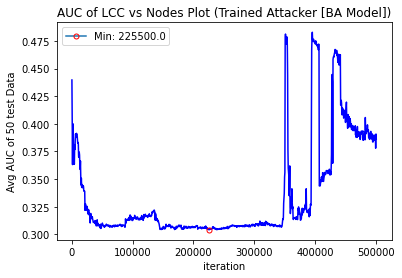

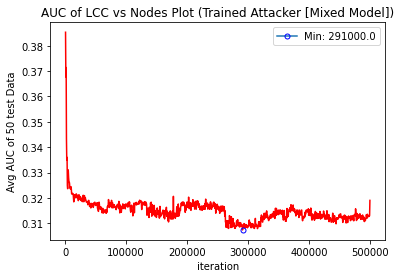

In [7]:
def lowest_AUC(x,value):
    lowest_auc_index = np.argmin(value)
    return x[lowest_auc_index], value[lowest_auc_index]
results_ts = np.array(results_ts)
print(results_ts.shape)     
print("BA Graph")
print(lowest_AUC(results_ts[0,0,:],results_ts[0,1,:]))
print("Different Graph")
print(lowest_AUC(results_ts[1,0,:],results_ts[1,1,:]))
for j in range(2):
    if j == 0:
        color = 'blue'
        inv = 'red'
    else:
        color = 'red'
        inv = 'blue'
    if j == 0:
        name = "(Trained Attacker [BA Model])"
        save = "BA"
        
    else:
        name = "(Trained Attacker [Mixed Model])"
        save = "Diff"                    
    min_vc, min_value = lowest_AUC(results_ts[j,0,:],results_ts[j,1,:])
    plt.plot(results_ts[j,0,:],results_ts[j,1,:], color)
    plt.plot(min_vc, min_value, marker="o", markersize=5, markeredgecolor=inv, markerfacecolor="None",label="Min: "+str(min_vc))
    plt.title("AUC of LCC vs Nodes Plot "+""+str(name)) 
    plt.xlabel("iteration")
    plt.ylabel("Avg AUC of "+str(len(evaluation)) +" test Data")
    plt.legend()
    #plt.savefig("./Figure/Validation/Test_TS_100_"+save)
    plt.show()
        

In [ ]:
from tqdm import tqdm
#path = "./model/DiffSize_Different_Graph/model_differentGraph_"
parameters = ["../utils/hyperparameters/BA/ba_params_Best.json"]
results_ts = []
for path in tqdm(range(1)):
    x, value = CV_evaluation(parameters[path])
    results_ts.append([x,value])
def lowest_AUC(x,value):
    lowest_auc_index = np.argmin(value)
    return x[lowest_auc_index], value[lowest_auc_index]
results_ts = np.array(results_ts)
print(results_ts.shape)     
print("BA Graph")
print(lowest_AUC(results_ts[0,0,:],results_ts[0,1,:]))

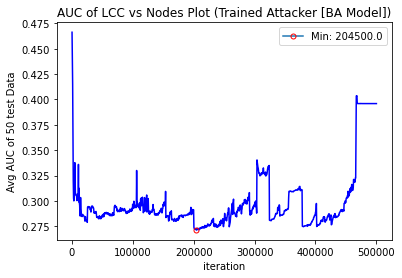

In [4]:
for j in range(1):
    if j == 0:
        color = 'blue'
        inv = 'red'
    else:
        color = 'red'
        inv = 'blue'
    if j == 0:
        name = "(Trained Attacker [BA Model])"
        save = "BA"
        
    else:
        name = "(Trained Attacker [Mixed Model])"
        save = "Diff"                    
    min_vc, min_value = lowest_AUC(results_ts[j,0,:],results_ts[j,1,:])
    plt.plot(results_ts[j,0,:],results_ts[j,1,:], color)
    plt.plot(min_vc, min_value, marker="o", markersize=5, markeredgecolor=inv, markerfacecolor="None",label="Min: "+str(min_vc))
    plt.title("AUC of LCC vs Nodes Plot "+""+str(name)) 
    plt.xlabel("iteration")
    plt.ylabel("Avg AUC of "+str(len(evaluation)) +" test Data")
    plt.legend()
    #plt.savefig("./Figure/Validation/Test_TS_100_"+save)
    plt.show()
        

# Results: Thompson Sampling

In [2]:
from tqdm import tqdm
#path = "./model/DiffSize_Different_Graph/model_differentGraph_"
model_path = ["../model/TS/BA_Graph/model_BAGraph_","../model/TS/Mix_Graph/model_differentGraph_"]
parameters = ["../utils/ba_params.json","../utils/mixed_params.json"]
results_ts = []
for path in tqdm(range(2)):
    x, value = CV_evaluation(model_path[path],parameters[path])
    results_ts.append([x,value])


100%|█████████████████████████████████████████| 2/2 [3:20:51<00:00, 6025.59s/it]


In [3]:
def lowest_AUC(x,value):
    lowest_auc_index = np.argmin(value)
    return x[lowest_auc_index], value[lowest_auc_index]
results_ts = np.array(results_ts)
print(results_ts.shape)     
print("BA Graph")
print(lowest_AUC(results_ts[0,0,:],results_ts[0,1,:]))
print("Different Graph")
print(lowest_AUC(results_ts[1,0,:],results_ts[1,1,:]))

(2, 2, 1000)
BA Graph
(273500.0, 13.341111920359682)
Different Graph
(138500.0, 9.80879813324664)


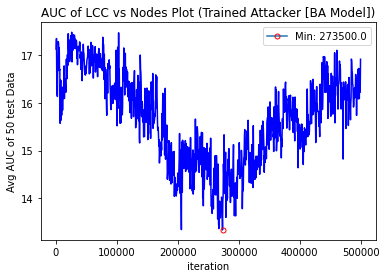

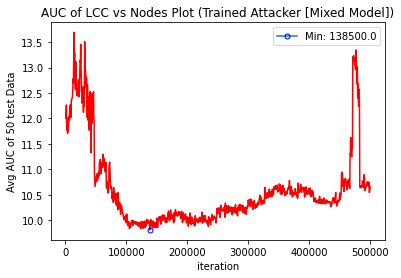

In [4]:
for j in range(2):
    if j == 0:
        color = 'blue'
        inv = 'red'
    else:
        color = 'red'
        inv = 'blue'
    if j == 0:
        name = "(Trained Attacker [BA Model])"
        save = "BA"
        
    else:
        name = "(Trained Attacker [Mixed Model])"
        save = "Diff"                    
    min_vc, min_value = lowest_AUC(results_ts[j,0,:],results_ts[j,1,:])
    plt.plot(results_ts[j,0,:],results_ts[j,1,:], color)
    plt.plot(min_vc, min_value, marker="o", markersize=5, markeredgecolor=inv, markerfacecolor="None",label="Min: "+str(min_vc))
    plt.title("AUC of LCC vs Nodes Plot "+""+str(name)) 
    plt.xlabel("iteration")
    plt.ylabel("Avg AUC of "+str(len(evaluation)) +" test Data")
    plt.legend()
    plt.savefig("./Figure/Validation/Test_TS_100_"+save)
    plt.show()
        

# Results: Random Greedy

In [5]:
from tqdm import tqdm
#path = "./model/DiffSize_Different_Graph/model_differentGraph_"
model_path = ["../model/DiffSize_BA_Graph/model_BAGraph_","../model/DiffSize_Different_Graph/model_differentGraph_"]
parameters = ["../utils/ba_params.json","../utils/mixed_params.json"]
results_rand = []
for path in tqdm(range(2)):
    x, value = CV_evaluation(model_path[path],parameters[path])
    results_rand.append([x,value])


100%|█████████████████████████████████████████| 2/2 [3:58:32<00:00, 7156.27s/it]


In [6]:
def lowest_AUC(x,value):
    lowest_auc_index = np.argmin(value)
    return x[lowest_auc_index], value[lowest_auc_index]
results_rand = np.array(results_rand)
print(results_rand.shape)     
print("BA Graph")
print(lowest_AUC(results_rand[0,0,:],results_rand[0,1,:]))
print("Different Graph")
print(lowest_AUC(results_rand[1,0,:],results_rand[1,1,:]))

(2, 2, 1000)
BA Graph
(289500.0, 12.146173581895521)
Different Graph
(492500.0, 9.622977318127717)


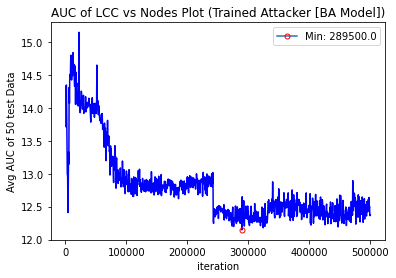

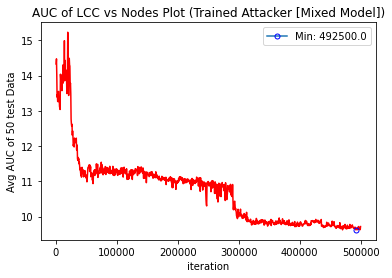

In [7]:
for j in range(2):
    if j == 0:
        color = 'blue'
        inv = 'red'
    else:
        color = 'red'
        inv = 'blue'
    if j == 0:
        name = "(Trained Attacker [BA Model])"
        save = "BA"
        
    else:
        name = "(Trained Attacker [Mixed Model])"
        save = "Diff"                    
    min_vc, min_value = lowest_AUC(results_rand[j,0,:],results_rand[j,1,:])
    plt.plot(results_rand[j,0,:],results_rand[j,1,:], color)
    plt.plot(min_vc, min_value, marker="o", markersize=5, markeredgecolor=inv, markerfacecolor="None",label="Min: "+str(min_vc))
    plt.title("AUC of LCC vs Nodes Plot "+""+str(name)) 
    plt.xlabel("iteration")
    plt.ylabel("Avg AUC of "+str(len(evaluation)) +" test Data")
    plt.legend()
    plt.savefig("./Figure/Validation/Test_Rand_100_"+save)
    plt.show()
        

## Feature of the Evaluation Dataset

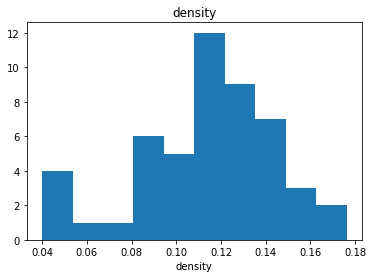

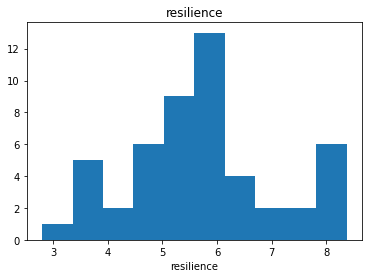

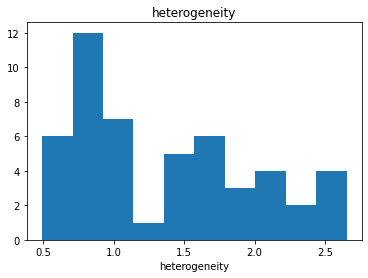

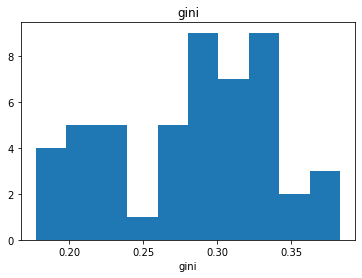

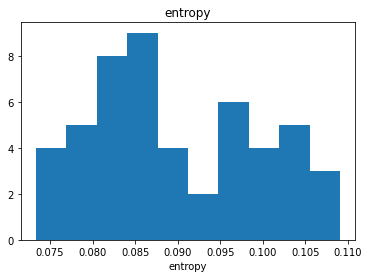

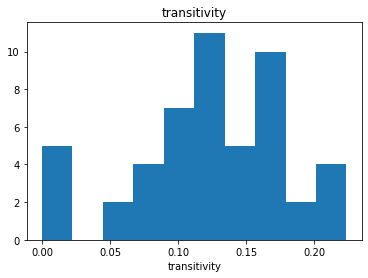

In [8]:
from scipy.stats import entropy
def globalfeature(g): 
    subGraph = g.to_networkx()
    M = len(subGraph.edges())
    N = len(subGraph)
    degs =   np.array(subGraph.degree())[:,1]
    k1 = degs.mean()
    k2 = np.mean(degs** 2)
    div = k2 - k1**2
    if k1 != 0:
        heterogeneity = div/k1
        density = (2*M)/(N*(N-1))
        resilience = k2/k1
        sorted_degs = sorted(degs)
        gini = sum([(i+1) * sorted_degs[i] for i in range(N)])/(M*N) - (N+1)/N
        entrop = entropy(degs/M)/N
        transitivity = nx.algorithms.cluster.transitivity(subGraph)
    else:
        heterogeneity = 0
        density = (2*M)/(N*(N-1))
        resilience = 0
        gini = 0
        entrop = 0
        transitivity = nx.algorithms.cluster.transitivity(subGraph)
    global_properties = np.hstack((density,resilience,heterogeneity,gini,entrop,transitivity))
    #global_properties = np.hstack((density,resilience,heterogeneity))
    return global_properties
feature = []
for g in evaluation:
    feature.append(globalfeature(g))
feature = np.array(feature)
label = ['density','resilience','heterogeneity','gini','entropy','transitivity']
for i in range(feature.shape[1]):
    plt.hist(feature[:,i])
    plt.title(label[i])
    plt.xlabel(label[i])
    #plt.savefig("./Cross_Validation/Validation/Histogram_200_"+label[i])
    plt.show()